In [1]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split #splits data for training and testing 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report

2024-12-11 12:53:49.309514: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 12:53:49.995064: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 12:53:49.997650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 12:53:54.350839: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
file_path = 'Brain_Data_Organised'

In [3]:
name_class = os.listdir(file_path)
name_class

['Normal', 'Stroke']

In [4]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [5]:
filepaths[-6:-1]

['Brain_Data_Organised/Stroke/93 (1).jpg',
 'Brain_Data_Organised/Stroke/88 (12).jpg',
 'Brain_Data_Organised/Stroke/70 (46).jpg',
 'Brain_Data_Organised/Stroke/91 (13).jpg',
 'Brain_Data_Organised/Stroke/84 (24).jpg']

In [6]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
labels

['Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',
 'Normal',

In [7]:

filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)

,Filepath,Label
0,Brain_Data_Organised/Normal/111 (13).jpg,Normal
1,Brain_Data_Organised/Stroke/77 (37).jpg,Stroke
2,Brain_Data_Organised/Stroke/72 (9).jpg,Stroke
3,Brain_Data_Organised/Normal/104 (27).jpg,Normal
4,Brain_Data_Organised/Normal/124 (10).jpg,Normal


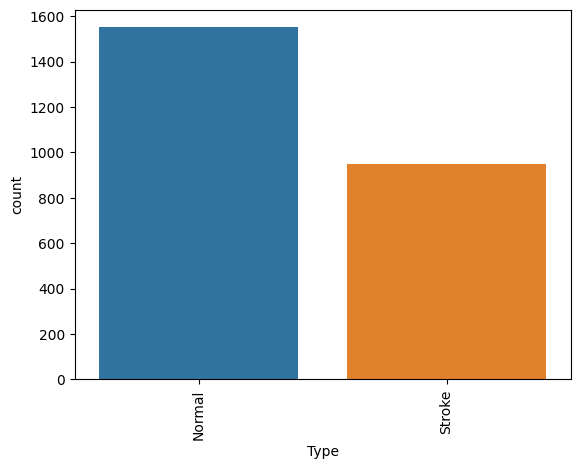

In [8]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [9]:
train, test = train_test_split(data, test_size=0.20, random_state=42)

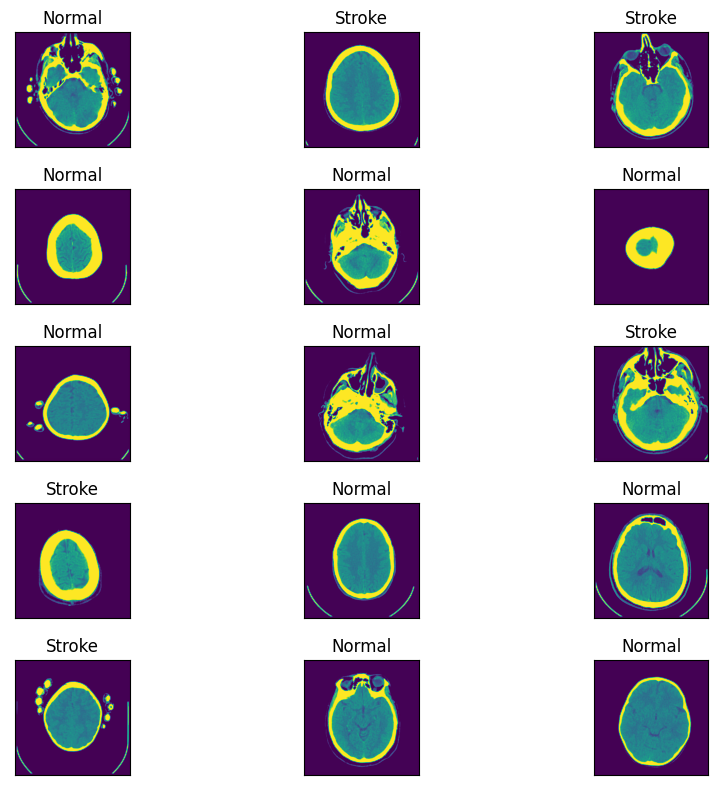

In [10]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [11]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [12]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2000 validated image filenames belonging to 2 classes.
Found 501 validated image filenames belonging to 2 classes.
Found 501 validated image filenames belonging to 2 classes.


In [15]:
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, Concatenate, Input
from tensorflow.keras.models import Model

# Define input
input_shape = (100, 100, 3)
inputs = Input(shape=input_shape)

# Load ResNet50
resnet50 = ResNet50(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
resnet50.trainable = False

# Load EfficientNetB0
efficientnetb0 = EfficientNetB0(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
efficientnetb0.trainable = False

# Get outputs from both models
resnet_output = resnet50(inputs)
efficientnet_output = efficientnetb0(inputs)

# Concatenate the outputs
merged = Concatenate()([resnet_output, efficientnet_output])

# Add dense layers
x = Dense(128, activation='relu')(merged)
x = Dense(128, activation='relu')(x)

# Output layer
outputs = Dense(2, activation='softmax')(x)

# Define the hybrid model
model = Model(inputs=inputs, outputs=outputs)

# Summary of the model
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 2048)         23587712    ['input_2[0][0]']                
                                                                                                  
 efficientnetb0 (Functional)    (None, 1280)         4049571     ['input_2[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 3328)         0           ['resnet50[0][0]',         

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [18]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20
)

Epoch 1/20


2024-12-11 13:02:21.192763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-11 13:02:57.838344: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20480000 exceeds 10% of free system memory.
2024-12-11 13:02:58.159775: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20480000 exceeds 10% of free system memory.
2024-12-11 13:02:58.249945: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 22151168 exceeds 10% of free system memory.
2024-12-11 13:02:58.301624: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20480000 exceeds 10% of free system memory.
2024-12-11 13:02:58.379790: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20480000 exceeds 10% of

16/63 [======>.......................] - ETA: 2:14 - loss: 1.1214 - accuracy: 0.5469

KeyboardInterrupt: 

In [ ]:
model.save("brain_stroke_hybrid_model.h5")  

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [ ]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

img_path = '58 (1).jpg'

img = image.load_img(img_path, target_size=(256,256))
x = image.img_to_array(img)

x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
result = model.predict(x)
print((result*100).astype('int'))
